# Where should a drinks company run promotions?

## 📖 Background
Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

### The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


In [2]:
import pandas as pd
df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')


# 1 Data lookup

## 1.1 Problem identification

Marketing team sad, that promotion in Saint Petersburg was very successful. We need to identify patterns, that describe wine consumption in Saint Petercburg. And then we will try to find other regions with similar patterns. Also we need to keep in mind that, regions in Russia are different and have different amount of population. Population is important because revenue(money) depends on the volume of alcohol sold. So the more people in region the more potencial buyers we have.

## 1.2 Looking at the data

First of all lets take a closer look at the presented data. 

In [3]:
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


We have info of alcohol consumption of different regions in Russia by year.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


The types of colums are as expected. Numerical columns have float format.

In [5]:
df.describe()

,year,wine,beer,vodka,champagne,brandy
count,1615.000000,1552.000000,1557.000000,1554.000000,1552.000000,1549.000000
mean,2007.000000,5.628144,51.260148,11.818694,1.313177,0.526998
std,5.478922,2.813208,25.372821,5.128806,0.797956,0.400201
min,1998.000000,0.100000,0.400000,0.050000,0.100000,0.000000
25%,2002.000000,3.575000,32.400000,8.300000,0.800000,0.200000
50%,2007.000000,5.400000,49.970000,11.500000,1.200000,0.400000
75%,2012.000000,7.377500,67.400000,15.000000,1.665000,0.700000
max,2016.000000,18.100000,207.300000,40.600000,5.560000,2.300000


We see, that wine consumption is on the third place generaly, after beer and vodka. The mean value and the median are close to each other, so we may assume that the distribution is close to normal.

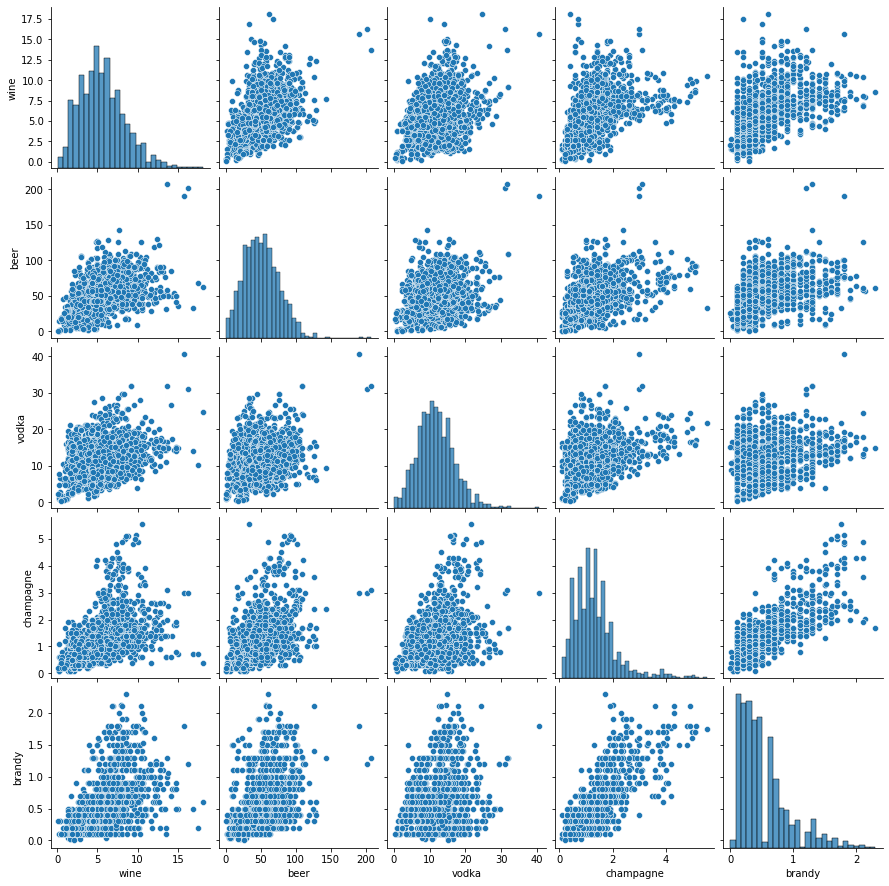

In [6]:
sns.pairplot(df.loc[:,'wine':'brandy'])

The numerical features skewed but not very high. We will not use them to create predictive models, so let them stay, as they are.

## 1.3 Finding missing values

In [7]:
pd.DataFrame(df.isna().mean()).style.format('{:.2%}').background_gradient('coolwarm')

,0
year,0.00%
region,0.00%
wine,3.90%
beer,3.59%
vodka,3.78%
champagne,3.90%
brandy,4.09%


We see that about 4% of the data a missed. Lets have a closer look at those values.

In [8]:
df[df['champagne'].isna()]['region'].unique() == df[df['brandy'].isna()]['region'].unique()

array([ True,  True,  True,  True])

In [9]:
na_regions = df[df['champagne'].isna()]['region'].unique()

In [10]:
pd.Series(na_regions)

0    Republic of Ingushetia
1        Republic of Crimea
2                Sevastopol
3          Chechen Republic
dtype: object

We have four regions with missing values. We can split this four for two groups.

First is Sevastopol and Republic of Crimea. This two was appended to Russia in 2014, so it is explainable why we dont have the information about the time before 2014. Crimea is big republic with population close to 2 million people, also it is a region with old tradicions of winemaking. For this two we will fill the NAs with zeroes.


Second is Republic of Ingushetia and Chechen Republic. This two are islamic republics where alcohol is prohibited, so we may assume that this two are definitely not our target audience. And we should drop them from our dataset.

## 1.4 Conclusion

We looked up at the data, found out some info about missing values and choose the way to fix them.

# 2 Data preparation

## 1.1 Processing missing values

As we assumed on the lookup stage we will drop rows for two regions with missing values (Republic of Ingushetia and Chechen Republic) and fill missing values with zeroes for Sevastopol and Republic of Crimea.

In [11]:
na_regions_to_drop = ['Republic of Ingushetia', 'Chechen Republic']

In [12]:
df = df.drop(df[df['region'].isin(na_regions_to_drop)].index)

All other missing values we will fill with 0.

In [13]:
df[df['vodka'].isna()]['region'].unique()

array(['Republic of Crimea', 'Sevastopol'], dtype=object)

In [14]:
df = df.fillna(0)

In [15]:
df.isna().mean()

year         0.0
region       0.0
wine         0.0
beer         0.0
vodka        0.0
champagne    0.0
brandy       0.0
dtype: float64

All NAs are processed.

## 1.2 Extracting features

The exact amount of consumed alcohol can be very diffirent from one region to another. Also wine is the third most popular alcohol drink after beer and vodka. So I suppose that we should check what share of total alcohol wine takes in differend regions yearly and explore how this share changes by time.

To do that we need to calculate total alcohol consumption of the region by year, and after that calculate wine share.

Let's define function.

In [16]:
def get_total_alcohol(row):
    '''Function calculates total amount of alcohol per row
    
    Args: row of the dataframe
    
    Returns: sum of values of all kinds of alcohol
    '''
    total = row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']
    return total

Now we will create new filds. And fill na values for Sevastopol and Crimea with 0.

In [17]:
df = df.assign(
    total_alcohol = lambda x: x.apply(get_total_alcohol, axis=1),
    wine_share = lambda x: x['wine'] / x['total_alcohol']
    ).fillna(0) # filling NAs with 0 for rows where total alcohol is 0 (for Crimea and Sevastopol)
    

In [18]:
df.head(2)

,year,region,wine,beer,vodka,champagne,brandy,total_alcohol,wine_share
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1,14.5,0.131034
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1,35.0,0.094286


## 1.3 Getting population info

Population of the region is very important feature, because it directly influences on the revenue. More people - more buyers.

To get population info I checked the official site of Russian Federal State Statistics Service ([link](https://rosstat.gov.ru/compendium/document/13282)) and downloaded the population by region info on 1 january 2021.

I translated the data to english and made some preparation to use it. After that I loaded the file to the working space on Datacamp.

Population data contains:

- "region"  - name of the subject
- "total_population" - number of people live in a region
- "urban_population" - number of people in region who live in a city
- "federal_state" - is a macroregion where region is located


In [19]:
population_info = pd.read_csv(r'./data/Regions_population.csv', sep=';')

In [20]:
population_info.head(2)

,region,total_population,urban_population,federal_state
0,Belgorod Oblast,1541259,1041310,CFO
1,Bryansk Oblast,1182682,833197,CFO


The data is preprocecced and ready to use.

# 3 Data analysis

## 3.1 Hypothesis

Lets look at the change of wine_share by year for Saint Peterburg.

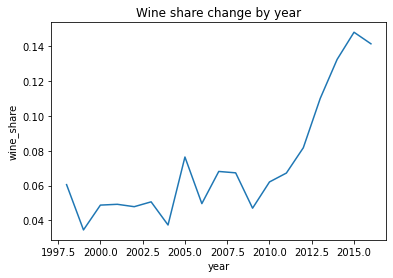

In [21]:
sns.lineplot(x=df[df.region == 'Saint Petersburg']['year'], y = df[df.region == 'Saint Petersburg']['wine_share'])
plt.xlabel('year')
plt.ylabel('wine_share')
plt.title('Wine share change by year')
plt.show()

As we see above wine consumtion share rised significantly from 2010 to 2015. So we can assume that in  past few years people in Saint Petersburg started to prefer wine to other alcohol types.

So our goal is to find regions where people also started to prefer wine instead of other types of alcohol.

## 3.2 Creating  analisys dataframe

We are going to make a pivot table with info of wine share for each region yearly.

In [22]:
years_info = df.pivot_table(index='region', columns='year', values = 'wine_share')

In [23]:
years_info.head(2)

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Altai Krai,0.094286,0.055556,0.045064,0.041591,0.028070,0.027375,0.028531,0.027816,0.034755,0.039308,0.052474,0.057927,0.054813,0.055962,0.054484,0.055346,0.064669,0.078712,0.100840
Altai Republic,0.165049,0.259459,0.192171,0.158333,0.119247,0.145455,0.150562,0.130152,0.085470,0.086176,0.093168,0.070694,0.078811,0.071788,0.065409,0.056604,0.078067,0.080224,0.082418


## 3.3 Making clusters

To find regions with similiar to Saint Petersburg rise of wine consumption we will try to use KMean algirithm from sklearn library and after that check the results manualy.

To get better results we should normalize the data, so the dinamic became more clear and compareable.

Define a function for min max normalization.

In [24]:
def min_max_normalization(row):
    ''' Function calculates normalized value for each cell in a dataframe row
    
    Args: row of the dataframe
    
    Returns: normalized value
    '''
    norm_value = (row - row.min())/(row.max() - row.min())
    return norm_value

Lets create a new dataframe with normalized information.

In [25]:
years_info_norm = years_info.apply(min_max_normalization, axis=1)

Now we create a KMean model with 8 clusters, we need to find 10 regions, so it would be nice if our model gives us 1/8 of 83 regions.

In [26]:
model = KMeans(n_clusters=8, random_state = 42)

In [27]:
model.fit(years_info_norm)

KMeans(random_state=42)

Create new column with cluster info.

In [28]:
years_info['clusters'] = model.labels_

Now we can find a cluster for Saint Petersburg.


In [29]:
spb_cluster = years_info.loc['Saint Petersburg','clusters']
print(f"Saint Petercburg is in cluster number: {spb_cluster}")

Saint Petercburg is in cluster number: 1


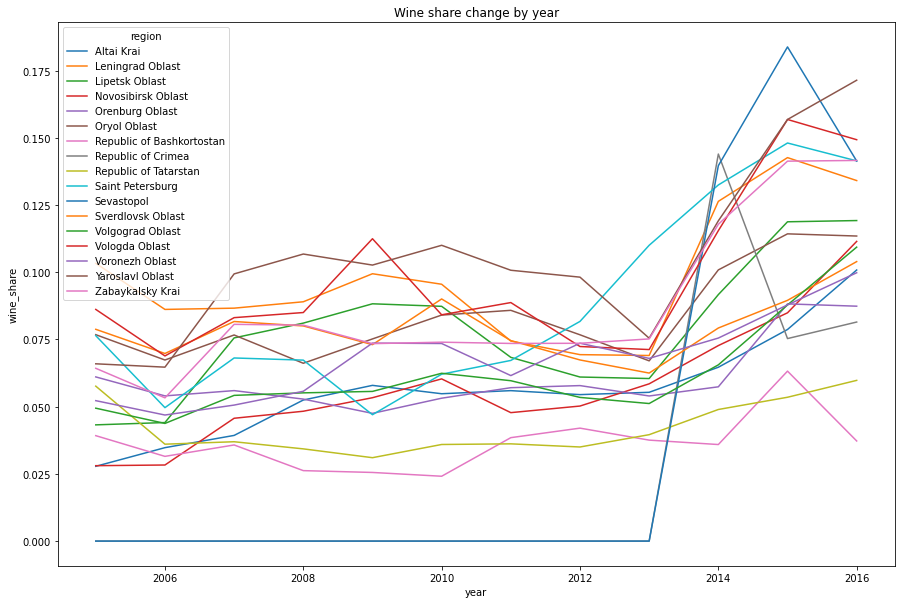

In [30]:
(years_info[(years_info['clusters'] == spb_cluster)]
         .loc[:,2005:2016]
         .T
         .plot(figsize=(15,10))
)
plt.xlabel('year')
plt.ylabel('wine_share')
plt.title('Wine share change by year')
plt.show()

As we can see above most regions in a cluster is characterized by rise of wine share in last four or three years. We can use this regions to promote wine.

In [31]:
growing_regions = years_info[years_info['clusters'] == spb_cluster].index

In [32]:
print(f"The KMeans algorithm choose {len(growing_regions)} regions similar to Saint Petersburg including it.")

The KMeans algorithm choose 17 regions similar to Saint Petersburg including it.


Lets look what with the other clusters.

We add cluster information to normalized dataframe and check how looks the dinamics in other clusters.

In [33]:
years_info_norm['clusters'] = model.labels_

We group iformation by each cluster and calculate mean value of normalized wine share. After doing so we will see the dinamics of the whole cluster.

In [34]:
years_info_norm.groupby('clusters').mean().style.format('{:.2f}').background_gradient('coolwarm')

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
clusters,,,,,,,,,,,,,,,,,,,
0,0.27,0.12,0.16,0.16,0.16,0.20,0.15,0.23,0.27,0.61,0.79,0.87,0.85,0.76,0.69,0.68,0.71,0.77,0.76
1,0.31,0.17,0.13,0.15,0.22,0.30,0.21,0.26,0.14,0.28,0.27,0.29,0.34,0.29,0.27,0.26,0.62,0.86,0.90
2,0.91,0.84,0.87,0.76,0.60,0.43,0.32,0.24,0.09,0.66,0.78,0.80,0.86,0.79,0.75,0.56,0.50,0.53,0.55
3,0.82,0.78,0.68,0.53,0.47,0.39,0.39,0.34,0.18,0.14,0.19,0.20,0.22,0.19,0.15,0.09,0.15,0.23,0.24
4,0.13,0.10,0.20,0.40,0.44,0.61,0.77,0.83,0.71,0.72,0.68,0.53,0.49,0.37,0.28,0.21,0.36,0.30,0.28
5,0.87,0.67,0.34,0.25,0.18,0.23,0.45,0.60,0.47,0.63,0.75,0.78,0.63,0.46,0.33,0.21,0.58,0.60,0.54
6,0.21,0.14,0.14,0.19,0.27,0.48,0.61,0.70,0.55,0.56,0.68,0.72,0.76,0.68,0.66,0.56,0.81,0.87,0.86
7,0.69,0.62,0.50,0.42,0.49,0.51,0.46,0.37,0.13,0.21,0.17,0.28,0.62,0.64,0.61,0.42,0.58,0.38,0.49


As we can see above the dinamic of the cluster number 1 is almost the same as the dinamic of Saint Petersburg. The trend is growing, wine consumtion is rising.

Another cluster with growing dinamic is the cluster number 6. Probably there is a reason to look for another region to promote in this cluster, after getting results from promotion ahead.

## 3.4 Choosing regions from cluster

After defining regions with rise of wine consumption we need to select the most profitable from them.

To do so we will calculate possible wine consumption in litres using information of region population and mean wine consumption over all time.

Getting mean wine consumption by each region.

In [35]:
df_mean_wine_info = df.groupby('region', as_index=False)['wine'].mean().rename(columns={'wine':'mean_wine'})
df_mean_wine_info.head()

,region,mean_wine
0,Altai Krai,3.174211
1,Altai Republic,5.190000
2,Amur Oblast,5.221579
3,Arkhangelsk Oblast,8.670000
4,Astrakhan Oblast,4.469474


Next we select information about population for regions with growing wine preferences and merge it with mean wine consumption information.

In [36]:
promoting_regions = (population_info[population_info['region'].isin(growing_regions)]
                     .sort_values(by='total_population', ascending=False)
                     .merge(df_mean_wine_info, on='region')
                    )

Now we will calculate possible amount of wine sold by year in this regions.

In [37]:
promoting_regions['thousands_liters_of_wine_consumed_yearly'] = round(promoting_regions['total_population'] 
                                                                      * promoting_regions['mean_wine'] 
                                                                      / 1000)

After sorting values by new calculated fild we see the most perspective regions to start promotion campaign. 


In [38]:
final_regions = (promoting_regions.sort_values(by='thousands_liters_of_wine_consumed_yearly', ascending=False)
                 .head(11)
                 .reset_index(drop=True)
                )
final_regions

,region,total_population,urban_population,federal_state,mean_wine,thousands_liters_of_wine_consumed_yearly
0,Saint Petersburg,5384342,5384342,SZFO,6.952632,37435.0
1,Sverdlovsk Oblast,4290067,3650725,UFO,7.382632,31672.0
2,Leningrad Oblast,1892711,1274208,SZFO,7.786316,14737.0
3,Republic of Tatarstan,3894120,2994450,PFO,3.058421,11910.0
4,Novosibirsk Oblast,2785836,2207966,SFO,4.205263,11715.0
5,Vologda Oblast,1151042,837220,SZFO,9.328421,10737.0
6,Voronezh Oblast,2305608,1567046,CFO,4.637895,10693.0
7,Volgograd Oblast,2474556,1915787,STHFO,4.027368,9966.0
8,Republic of Bashkortostan,4013786,2510951,PFO,2.396842,9620.0
9,Yaroslavl Oblast,1241424,1011966,CFO,7.193158,8930.0


As we can see Saint Petersburg is on the first place, so we should not expect the same outcome from other regions and also we need to thank our marketing team to choose Saint Petersburg as target of the first campaign.

Let's save the final list of regions to present to marketing team.

In [39]:
final_regions_list = final_regions[final_regions['region'] != 'Saint Petersburg']['region']

# 4 Results

During the research we made the following:
- Discovered that wine consumption in Saint Petersburg showed significant rise in past few years.
- With using the simple KMeans algorithm we selected other regions with simillar dinamic.
- With population data and mean wine consumption we selected 10 regions to start a new promotion campaign.

The regions to promote are:

In [40]:
display(pd.DataFrame(final_regions_list))

,region
1,Sverdlovsk Oblast
2,Leningrad Oblast
3,Republic of Tatarstan
4,Novosibirsk Oblast
5,Vologda Oblast
6,Voronezh Oblast
7,Volgograd Oblast
8,Republic of Bashkortostan
9,Yaroslavl Oblast
10,Altai Krai
